In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
cases.date = pd.to_datetime(cases.date)
cases = cases[(cases.county == "Harris") & (cases.state == "Texas")]
cases = cases.pivot(index="date", columns="fips", values="cases").diff().rolling(7).mean()
cases.columns = ["cases"]
# cases

In [3]:
uncert = pd.concat(map(pd.read_csv, glob("../data/Houston_output/window_5_step_5/*/uncert.csv")))
uncert["date"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[0]))
# uncert["end"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[-1]))
uncert = uncert.set_index("date").drop(columns=["graph_name"])
uncert = uncert.reindex(pd.date_range(uncert.index.min(), uncert.index.max(), freq=f"{5}D"))
uncert = uncert.fillna(0)
uncert = uncert.reindex(cases.index)
uncert = uncert.fillna(method="ffill")
uncert = uncert.replace(0, np.nan)

uncert.columns = ["full_none", "full_genomes", "full_seqs", "full_genomes+seqs", "collapsed_none", "collapsed_genomes", "collapsed_seqs", "collapsed_genomes+seqs"]

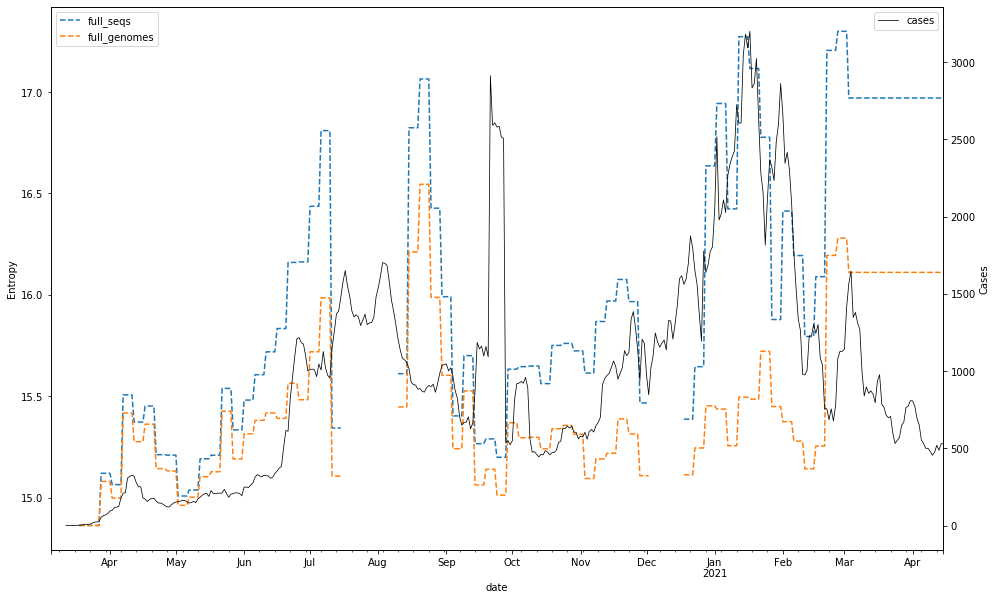

In [24]:
uncert_full = uncert[["full_seqs", "full_genomes"]]

fig, ax = plt.subplots(figsize=(16,10))

twinx = ax.twinx()

uncert_full.plot(ax=ax, linestyle="--")
cases.plot(ax=twinx, color="k", linewidth=0.75)

ax.set_ylabel("Entropy")
twinx.set_ylabel("Cases")
plt.savefig("full_seqs_houston_5_days.png")

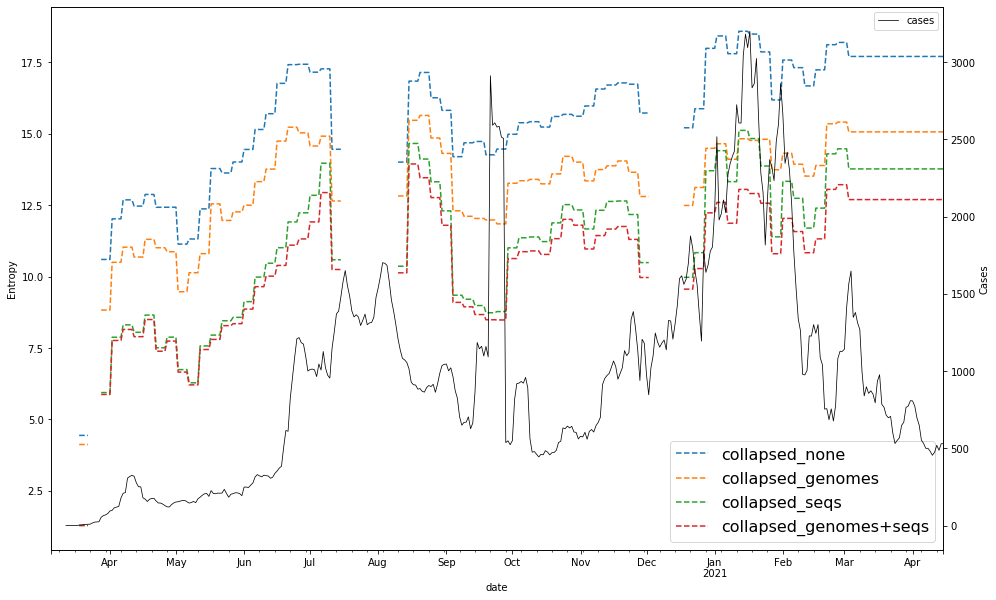

In [26]:
uncert_collapsed = uncert[[c for c in uncert.columns if "collapsed" in c]]

fig, ax = plt.subplots(figsize=(16,10))

twinx = ax.twinx()

uncert_collapsed.plot(ax=ax, linestyle="--")
cases.plot(ax=twinx, color="k", linewidth=0.75)

ax.set_ylabel("Entropy")
twinx.set_ylabel("Cases")
ax.legend(fontsize=16)
plt.savefig("collapsed_seqs_houston_5_days.png", dpi=100)

In [ ]:
data_loc = "New_York_City"

location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
uncerts = []
for path in location_data:
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
    uncerts.append(df)

uncert = pd.concat(uncerts)
uncert = uncert.groupby("date").max().drop(columns=["graph_name"]) #.dropna()
print(uncert.index)

if diff:
    uncert = uncert.diff()
uncert = uncert[[c for c in uncert.columns if c not in ["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"]]]


if uncert.index.min() < cases.index.min():
    uncert = uncert.iloc[1:]
uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
uncert = uncert.reindex(uncert_cases.resample("7D").sum().index)
uncert = uncert.replace(0, -1)
uncert = uncert.fillna(0)
uncert = uncert.reindex(uncert_cases.index)
uncert = uncert.fillna(method="ffill")
uncert = uncert.replace(0, np.nan)
uncert = uncert.replace(-1, 0)
uncert.loc["2020-06-01":].head(30)

In [4]:
import pickle
loc_date_samples = pickle.load(open("loc_date_samples.pkl", "rb"))

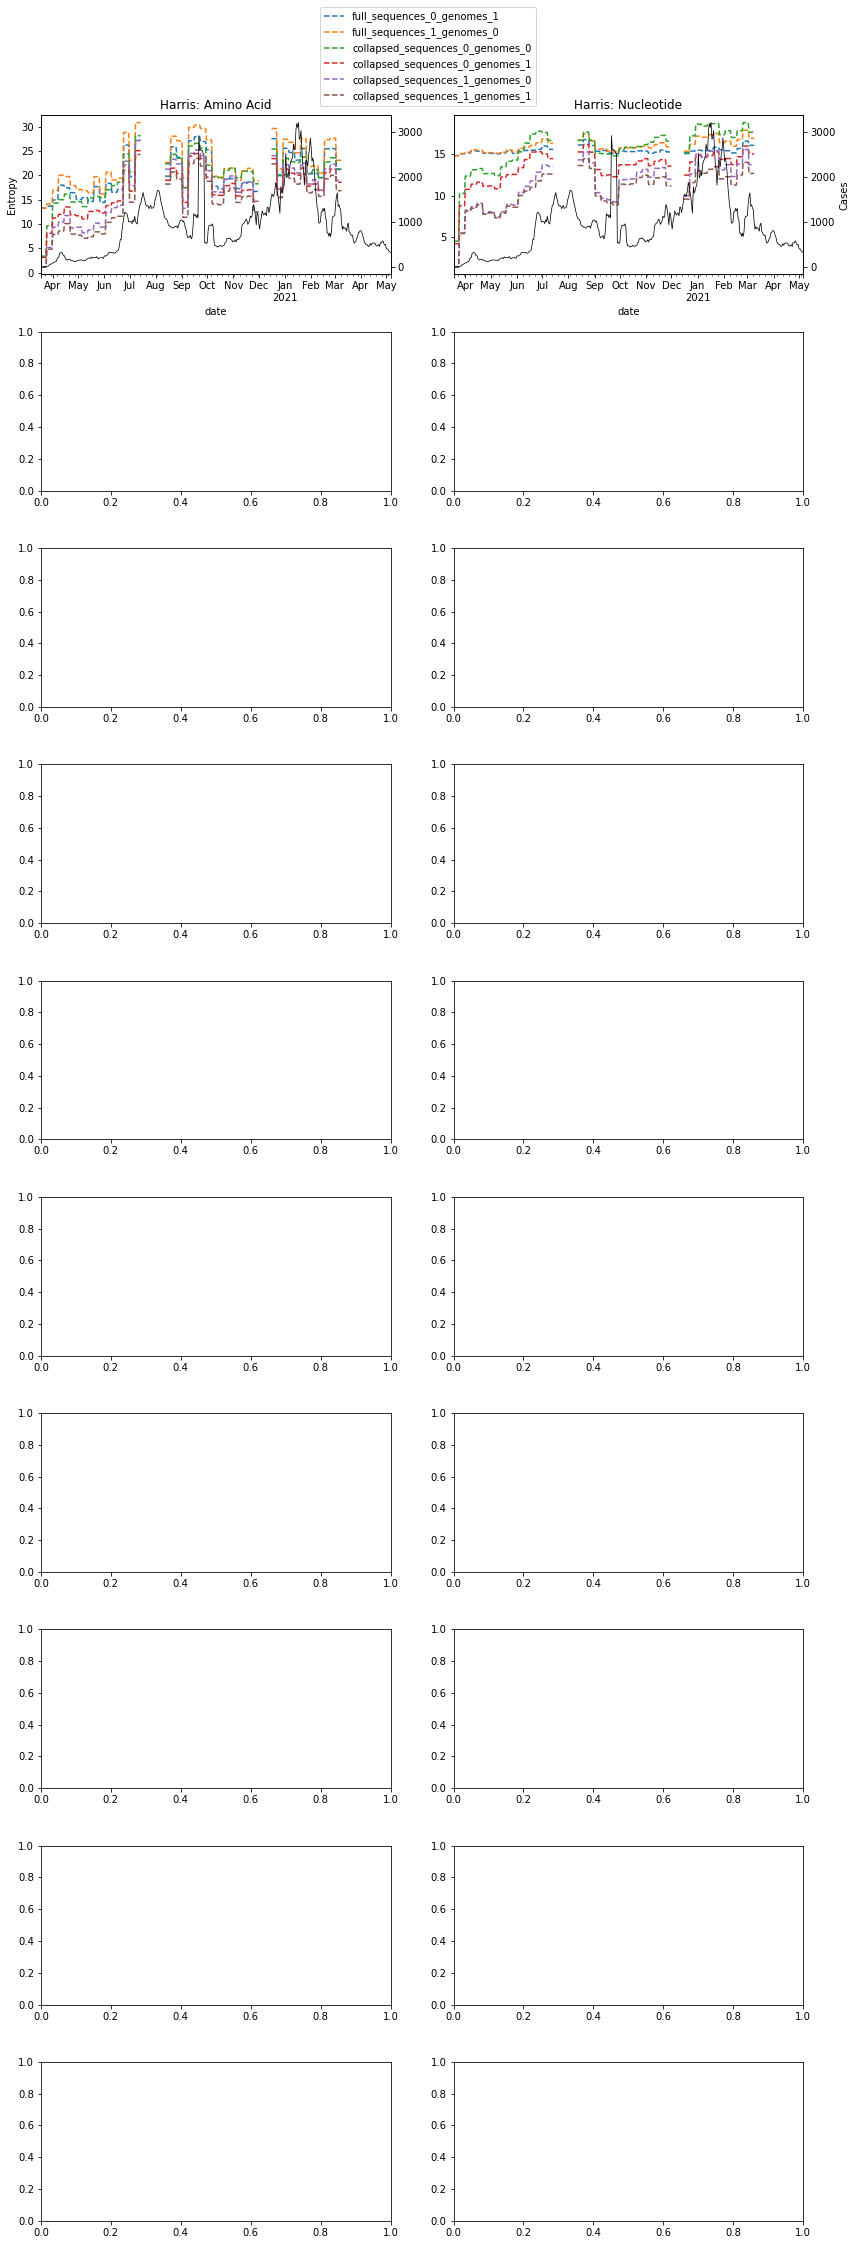

In [5]:
nyt_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
nyt_cases.date = pd.to_datetime(nyt_cases.date)

rolling=True
diff=False

fig, axs = plt.subplots(10,2, figsize=(12,30))

locations = [('Texas', 'Harris', "Houston"),
             ('New York', 'New York City', "New_York_City"),
             ('California', 'San Diego', "San_Diego"),
             ('California', 'Santa Clara', "Santa_Clara_County"),
             ('Wisconsin', 'Dane', "Dane_County"),
             ('California', 'Alameda', "Alameda_County"),
             ('Washington', 'Yakima', "Yakima_County"),
             ('Washington', 'King', "King_County"),
             ('California', 'Orange', "Orange_County"),
             ('California', 'Los Angeles', "Los_Angeles_County")]

ix = 0
for state, location, data_loc in locations:
    ax1 = axs[ix,0]
    ax2 = axs[ix,1]
    cases = nyt_cases[(nyt_cases.state == state) & (nyt_cases.county == location)]
    cases = cases.pivot(index="date", columns="fips", values="cases")
    cases = cases.diff()
    if rolling:
        cases = cases.rolling(7).mean() #Should I take the mean here?
    cases.columns = ["cases"]
    
    location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
    uncerts = []
    for path in location_data:
        df = pd.read_csv(path)
        df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
        uncerts.append(df)

    uncert = pd.concat(uncerts)
    uncert = uncert.groupby("date").max().drop(columns=["graph_name"]) #.dropna()
    if diff:
        uncert = uncert.diff()
    uncert = uncert[[c for c in uncert.columns if c not in ["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"]]]
    
    if uncert.index.min() < cases.index.min():
        uncert = uncert.iloc[1:]
    uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
    uncert = uncert.reindex(uncert_cases.resample("7D").sum().index)
    uncert = uncert.replace(0, -1)
    uncert = uncert.fillna(0)
    uncert = uncert.reindex(uncert_cases.index)
    uncert = uncert.fillna(method="ffill")
    uncert = uncert.replace(0, np.nan)
    uncert = uncert.replace(-1, 0)

#     if uncert.index.min() < cases.index.min():
#         uncert = uncert.iloc[1:]
#     uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
#     uncert = uncert.fillna(0)
#     uncert = uncert.reindex(uncert_cases.index)
#     uncert = uncert.fillna(method="ffill")
#     uncert = uncert.replace(0, np.nan)
    handles_labels = []
    for ax_ix, cur_ax in enumerate([ax1,ax2]):
        if ax_ix == 0:
            columns = [c for c in uncert.columns if "aa" in c]
        else:
            columns = [c for c in uncert.columns if not "aa" in c]
            
#         print(columns)
        twinx = cur_ax.twinx()

        uncert[columns].plot(ax=cur_ax, linestyle="--")
        uncert_cases.plot(ax=twinx, color="k", linewidth=0.75)
        
        if ax_ix == 0:
            cur_ax.set_ylabel("Entropy")
        else:
            twinx.set_ylabel("Cases")
            handles_labels.append(cur_ax.get_legend_handles_labels())
            
#         cur_ax.legend(fontsize=9)
        
        twinx.get_legend().remove()
        cur_ax.get_legend().remove()
        cur_ax.set_title(f"{location}: {'Amino Acid' if ax_ix == 0 else 'Nucleotide'}")
    
    ix += 1
    break
# uncert
fig.legend(handles_labels[0][0], handles_labels[0][1], bbox_to_anchor=(0.63, 1.04))
plt.tight_layout()
# plt.savefig("output/all_locations_entropy_and_cases_curves.png", dpi=100, bbox_inches="tight")

In [7]:
samples

NameError: name 'samples' is not defined

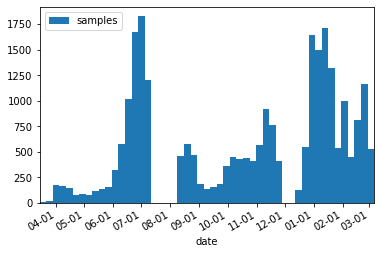

In [65]:

fig, ax = plt.subplots()
relevant_records = [loc for loc in loc_date_samples if loc[0] == "Houston"]
x = pd.DataFrame.from_records(relevant_records, columns=["location", "date", "samples"])
x = x.set_index(pd.to_datetime(x.date)).drop(columns=["date", "location"])
# index = pd.date_range(x.index.min(), x.index.max() + np.timedelta64(6, "D")) 
# x = x.reindex(index).fillna(method="ffill")
x.plot(kind="bar", ax=ax, width=7)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
fig.autofmt_xdate()

In [ ]:
loc_date_samples

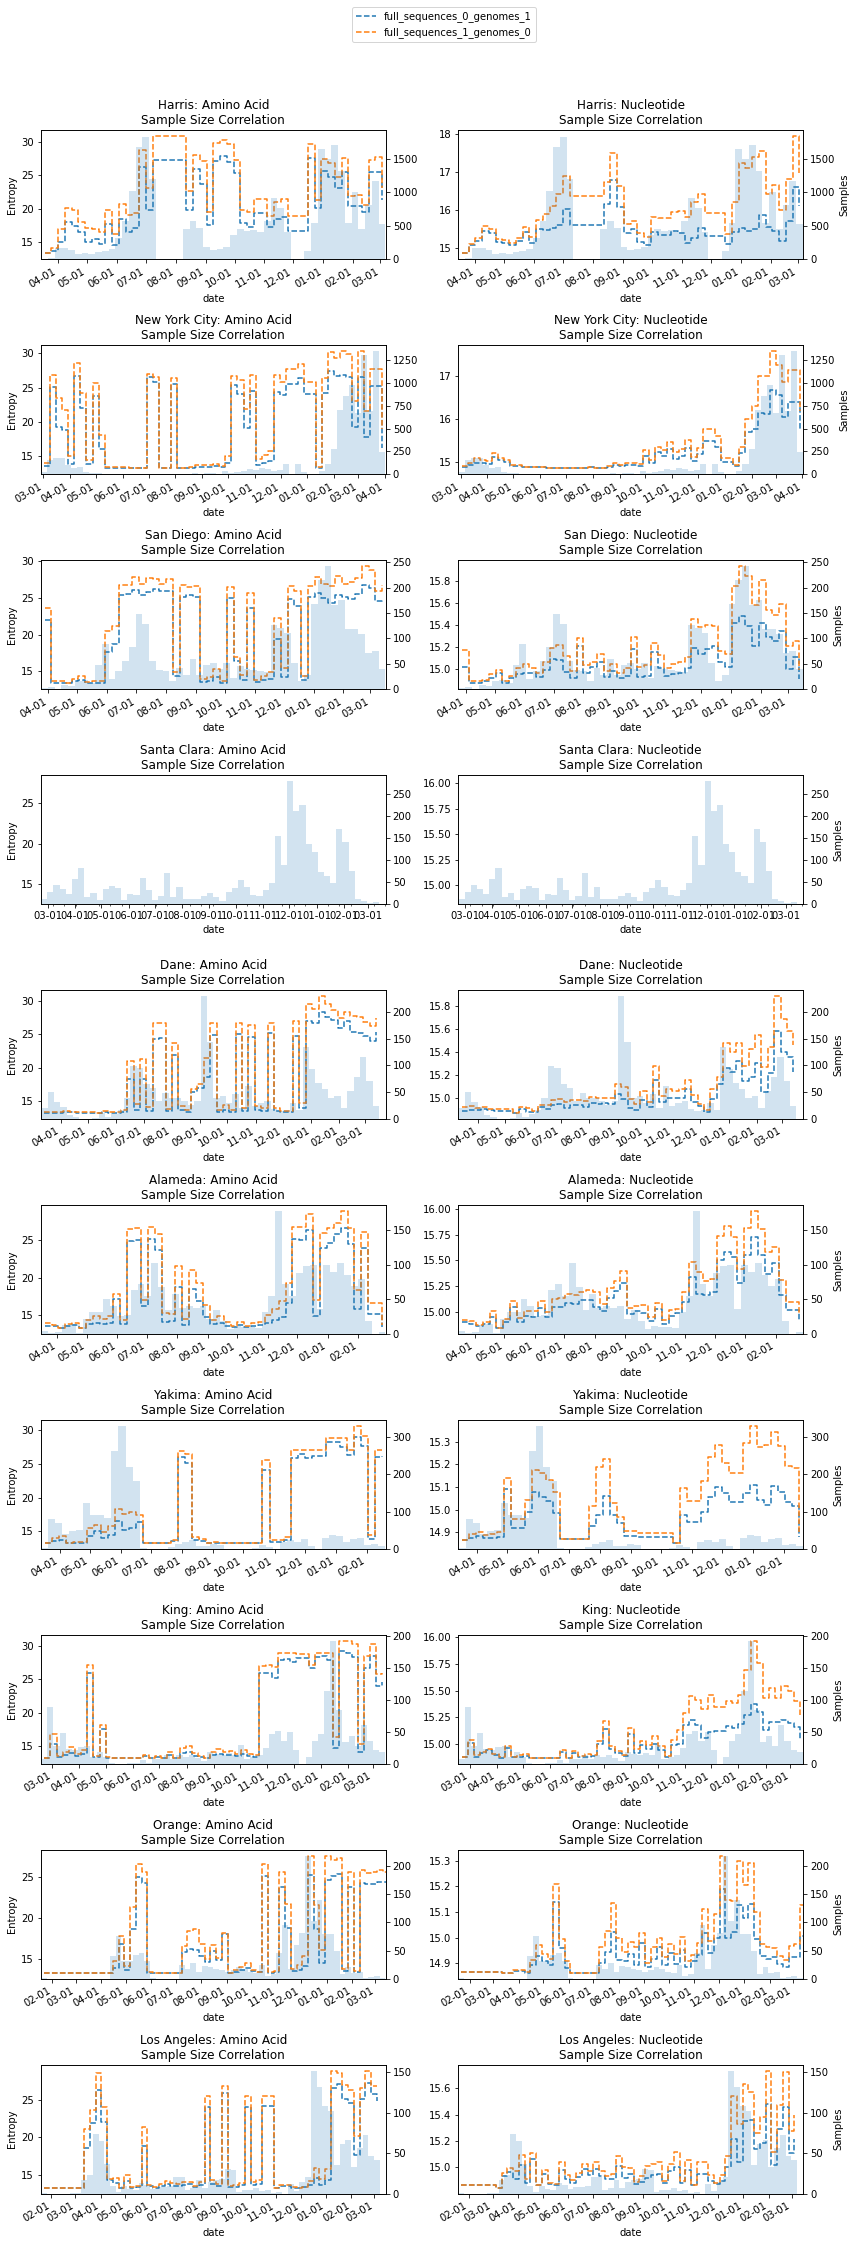

In [6]:
nyt_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
nyt_cases.date = pd.to_datetime(nyt_cases.date)

rolling=True
diff=False

fig, axs = plt.subplots(10,2, figsize=(12,30))

locations = [('Texas', 'Harris', "Houston"),
             ('New York', 'New York City', "New_York_City"),
             ('California', 'San Diego', "San_Diego"),
             ('California', 'Santa Clara', "Santa_Clara_County"),
             ('Wisconsin', 'Dane', "Dane_County"),
             ('California', 'Alameda', "Alameda_County"),
             ('Washington', 'Yakima', "Yakima_County"),
             ('Washington', 'King', "King_County"),
             ('California', 'Orange', "Orange_County"),
             ('California', 'Los Angeles', "Los_Angeles_County")]

ix = 0
loc_sample_uncerts = []
for state, location, data_loc in locations:
    ax1 = axs[ix,0]
    ax2 = axs[ix,1]
    cases = nyt_cases[(nyt_cases.state == state) & (nyt_cases.county == location)]
    cases = cases.pivot(index="date", columns="fips", values="cases")
    cases = cases.diff()
    if rolling:
        cases = cases.rolling(7).mean() #Should I take the mean here?
    cases.columns = ["cases"]
    
    location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
    uncerts = []
    for path in location_data:
        df = pd.read_csv(path)
        df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
        uncerts.append(df)

    uncert = pd.concat(uncerts)
    uncert = uncert.groupby("date").max().drop(columns=["graph_name"]) #.dropna()
    if diff:
        uncert = uncert.diff()
    uncert = uncert[[c for c in uncert.columns if c not in ["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"]]]
    
#     print(data_loc.replace("_", " "))
    relevant_records = [loc for loc in loc_date_samples if loc[0] == data_loc.replace("_", " ")]
    samples = pd.DataFrame.from_records(relevant_records, columns=["location", "date", "samples"])
    samples.date = pd.to_datetime(samples.date)    
    
#     print(index)
    samples = samples.set_index("date").drop(columns=["location"])
#     print(samples.index.min())
#     index = pd.date_range(samples.index.min(), samples.index.max())
# #     samples = samples.reindex(index).fillna(method="ffill")
    
#     uncert = uncert.reindex(samples.index)
#     uncert = uncert.replace(0, -1)
#     uncert = uncert.fillna(0)
#     uncert = uncert.reindex(index)
#     uncert = uncert.fillna(method="ffill")
#     uncert = uncert.replace(0, np.nan)
#     uncert = uncert.replace(-1, 0)

#     if uncert.index.min() < cases.index.min():
#         uncert = uncert.iloc[1:]
#     uncert_cases = cases.loc[uncert.index.min():] #.resample("7D").sum().diff()
#     uncert = uncert.fillna(0)
#     uncert = uncert.reindex(uncert_cases.index)
#     uncert = uncert.fillna(method="ffill")
#     uncert = uncert.replace(0, np.nan)
    sample_uncert = uncert.copy()
    sample_uncert["samples"] = samples
    sample_uncert["location"] = location
    loc_sample_uncerts.append(sample_uncert)
    handles_labels = []
    for ax_ix, cur_ax in enumerate([ax1,ax2]):
        if ax_ix == 0:
            columns = [c for c in uncert.columns if "aa" in c and "full" in c]
        else:
            columns = [c for c in uncert.columns if not "aa" in c and "full" in c]
            
#         print(columns)
#         if location == "Santa Clara":
#             st_uncert = uncert.copy()
#             st_samples = samples.copy()
#             print(ax, uncert[columns].head(1))

        uncert[columns].plot(drawstyle="steps-post", ax=cur_ax, linestyle="--")
        twinx = cur_ax.twinx()
        samples.plot(kind="bar", ax=twinx, width=7, alpha=0.2)

#         sample_uncert = uncert[columns]
#         sample_uncert["samples"] = samples
#         sample_uncert["location"] = location
#         loc_sample_uncerts.append(sample_uncert)
#         sample_uncert.corr()["samples"].iloc[:-1].plot.barh(ax=cur_ax)
        
#         samples.plot(kind="bar", ax=twinx, color="k")
#         cur_ax.set_xlabel("Correlation")
#         cur_ax.set_xlim(0,1)
        
        if ax_ix == 0:
            cur_ax.set_ylabel("Entropy")
#             cur_ax.set_ylabel("Model")
        else:
            twinx.set_ylabel("Samples")
            handles_labels.append(cur_ax.get_legend_handles_labels())
            
#         cur_ax.legend(fontsize=9)
        
        twinx.get_legend().remove()
        cur_ax.get_legend().remove()
        cur_ax.set_title(f"{location}: {'Amino Acid' if ax_ix == 0 else 'Nucleotide'}\nSample Size Correlation")
        twinx.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
        twinx.xaxis.set_major_locator(mdates.MonthLocator())
    ix += 1
#     break
# uncert
fig.legend(handles_labels[0][0], handles_labels[0][1], bbox_to_anchor=(0.63, 1.04))
plt.tight_layout()
# fig.savefig("output/all_locations_entropy_and_sample_size_full.png", dpi=100, bbox_inches="tight", transparent=False, facecolor="white")

In [35]:
colors = "blue orange green red purple brown pink gray olive cyan".split()
colors = ["tab:" + c for c in colors]
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [37]:
sample_uncerts = pd.concat([i.reset_index(drop=True) for i in  loc_sample_uncerts], ignore_index=True, axis=0)
sample_uncerts["location_color"] = sample_uncerts.location.astype("category").cat.codes
sample_uncerts.location_color = sample_uncerts.location_color.apply(lambda row: colors[row])
# sample_uncerts[sample_uncerts.location == "New York City"]

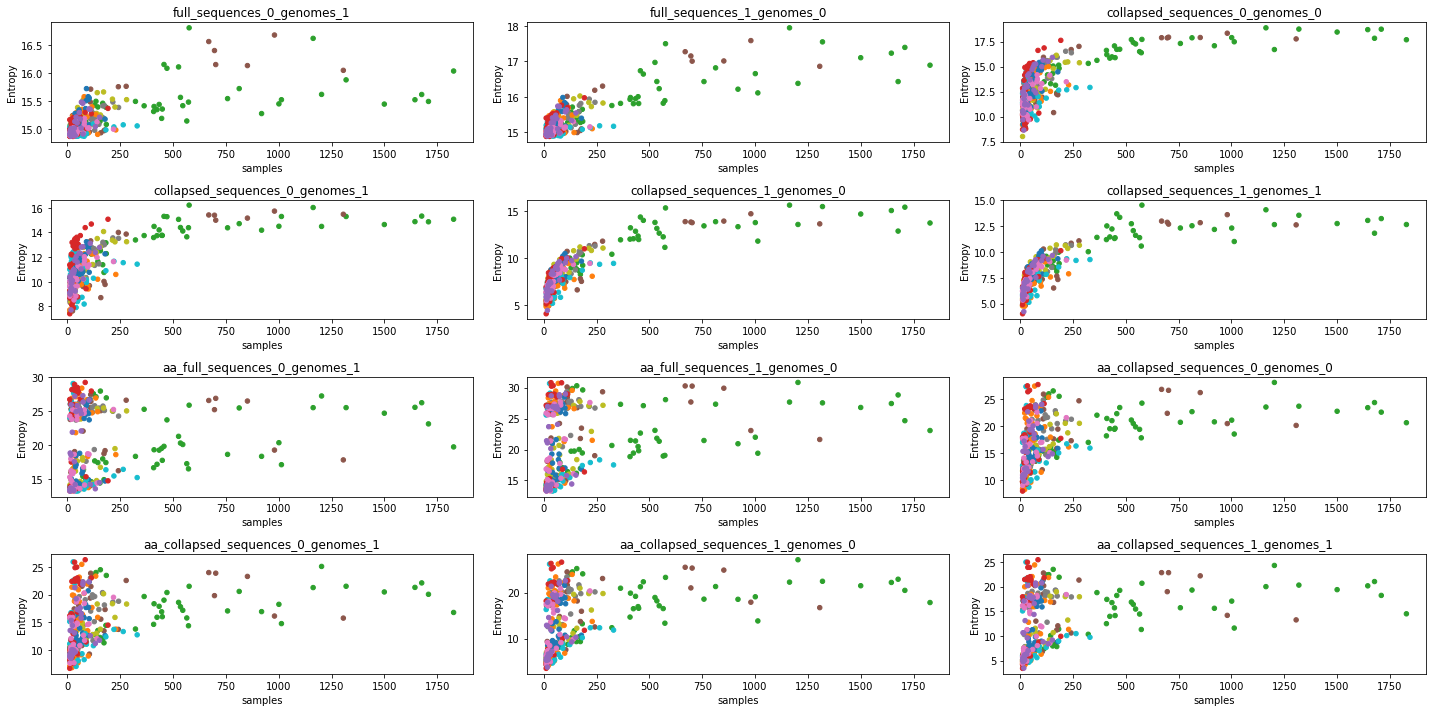

In [42]:
fig, axs = plt.subplots(4, 3, figsize=(20,10))
plot_samples_uncerts = sample_uncerts[sample_uncerts.samples > 10]
# plot_samples_uncerts = plot_samples_uncerts[plot_samples_uncerts.samples < 300]
ix = 0
for col in sample_uncerts.columns:
    if col in ["samples", "location", "location_color"]:
        continue
        
    ax = axs[ix//3, ix %3]
    ix += 1
    plot_samples_uncerts.plot.scatter(x="samples", y=col, color=plot_samples_uncerts.location_color, ax=ax)
    ax.set_ylabel("Entropy")
    ax.set_title(col)
plt.tight_layout()
plt.savefig("output/entropy_by_samples_10_to_300.png", dpi=100, facecolor="white")

In [17]:
sample_uncerts[sample_uncerts.samples < 5][["samples", "location_color"]]

,samples,location_color
0,2.0,2
56,1.0,5
57,3.0,5
58,3.0,5
59,1.0,5
60,4.0,5
61,2.0,5
62,1.0,5
63,3.0,5
93,3.0,7


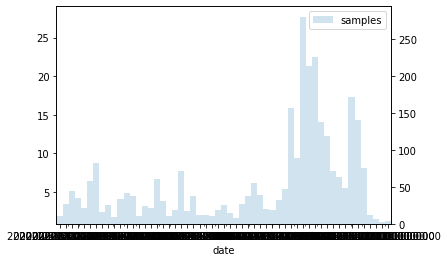

In [125]:
fig, ax = plt.subplots()
twinx = ax.twinx()
uncert.plot(drawstyle="steps-post", ax=ax, legend=False)
samples.reindex(uncert.index).plot(ax=twinx, kind="bar", width=7, alpha=0.2)

<AxesSubplot:>

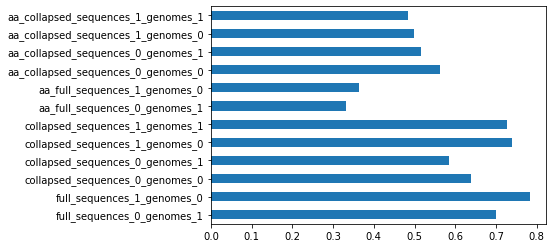

In [45]:
sampled_samples = samples[samples.index.isin(uncert.index)]
uncert["samples"] = samples
uncert.corr()["samples"].iloc[:-1].plot.barh()

In [18]:
uncert.index

DatetimeIndex(['2020-01-23', '2020-02-27', '2020-03-05', '2020-03-12',
               '2020-03-19', '2020-03-26', '2020-04-02', '2020-04-09',
               '2020-04-16', '2020-04-23', '2020-04-30', '2020-05-07',
               '2020-05-14', '2020-05-21', '2020-05-28', '2020-06-04',
               '2020-06-11', '2020-06-18', '2020-06-25', '2020-07-02',
               '2020-07-09', '2020-07-16', '2020-07-23', '2020-07-30',
               '2020-08-06', '2020-08-13', '2020-08-20', '2020-08-27',
               '2020-09-03', '2020-09-10', '2020-09-17', '2020-09-24',
               '2020-10-01', '2020-10-08', '2020-10-15', '2020-10-22',
               '2020-10-29', '2020-11-05', '2020-11-19', '2020-11-26',
               '2020-12-03', '2020-12-10', '2020-12-17', '2020-12-24',
               '2020-12-31', '2021-01-07', '2021-01-14', '2021-01-21',
               '2021-01-28', '2021-02-04', '2021-02-11', '2021-02-18',
               '2021-02-25', '2021-03-04'],
              dtype='datetime64[n

In [107]:
uncert.index.shape

(55,)

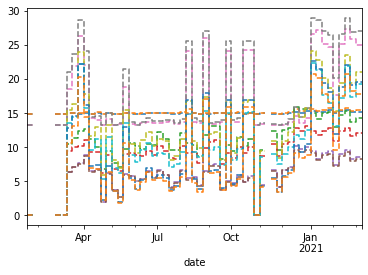

In [92]:
uncert.plot(drawstyle="steps-post", linestyle="--", legend=None)

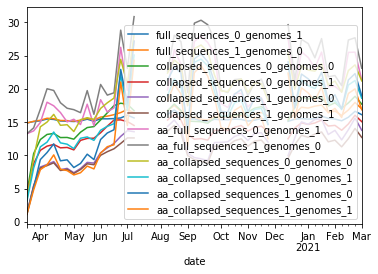

In [34]:
uncert.reindex(samples.index).plot()